In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['sofa_renal_baseline'] == 0]

    # design_matrix['sofa_renal_diff2'] = design_matrix['sofa_renal_day2'] - design_matrix['sofa_renal_baseline']
    # design_matrix['sofa_renal_diff3'] = design_matrix['sofa_renal_day3'] - design_matrix['sofa_renal_baseline']
    # design_matrix['sofa_renal_diff1'] = design_matrix['sofa_renal_day1'] - design_matrix['sofa_renal_baseline']

    design_matrix['max_renal_diff'] = np.max(
        design_matrix[
            [
                'sofa_renal_day1', 
                'sofa_renal_day2', 
                'sofa_renal_day3'
            ]
        ], 
        axis=1
    )

    design_matrix['group'] = np.where(
        design_matrix['max_renal_diff'] > 0, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix       


# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

/tmp/ipykernel_1034521/558351647.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['max_renal_diff'] = np.max(
/tmp/ipykernel_1034521/558351647.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['group'] = np.where(
/tmp/ipykernel_1034521/558351647.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

<Axes: xlabel='max_renal_diff', ylabel='Count'>

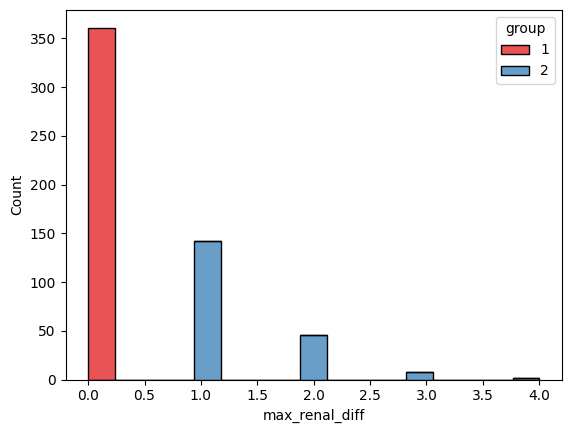

In [7]:
sns.histplot(
    design_matrix_train,
    x="max_renal_diff",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [8]:
design_matrix_train['group'].value_counts()

group
1    361
2    198
Name: count, dtype: int64

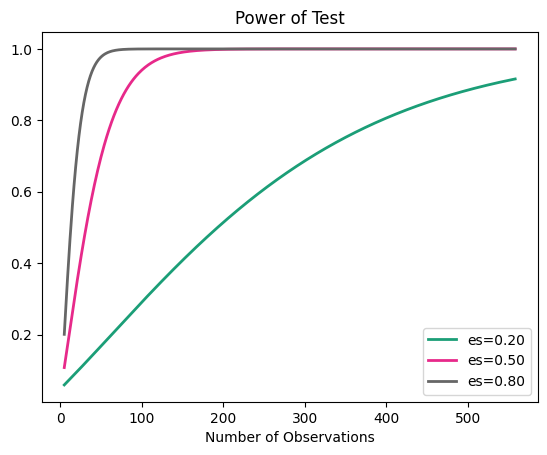

In [9]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [10]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [11]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_train.write("de_results/renal_de_proteins.tsv")

In [13]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

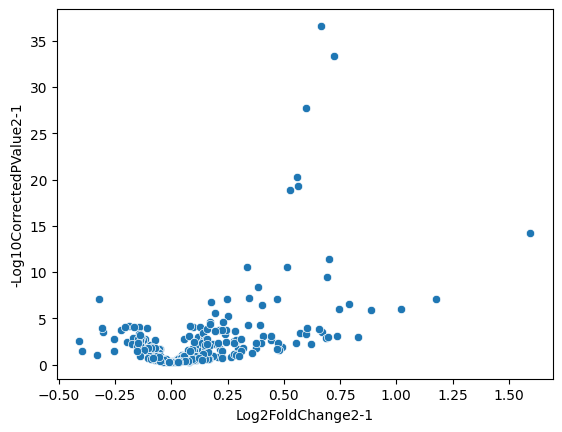

In [14]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [15]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [16]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [17]:
protein_columns = training_data.columns.to_list()

In [18]:
len(protein_columns)

287

In [19]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf,
#     random_state=42
# )

In [21]:
# from cleanlab.filter import find_label_issues
# from sklearn.model_selection import cross_val_predict

# pred_probs = cross_val_predict(protein_clf, X, y.values.ravel(), cv=3, method="predict_proba")

# label_issues = find_label_issues(
#     labels=y.values.ravel(),
#     pred_probs=pred_probs,
#     return_indices_ranked_by='self_confidence'  # Ranks by likelihood of being mislabeled
# )

In [22]:
# mask = np.ones(len(y.values.ravel()), dtype=bool)

# mask[label_issues] = False

In [23]:
# X = X.iloc[mask, :].copy()
# y = y.iloc[mask, :].copy()

In [24]:
y['label'].value_counts()

label
0    361
1    198
Name: count, dtype: int64

In [25]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.7742382271468145, 1: 1.4116161616161615}

In [26]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [27]:
len(protein_columns)

287

In [28]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


In [29]:
selected_proteins

['CYTC_HUMAN',
 'ITB3_HUMAN',
 'B2MG_HUMAN',
 'CFAD_HUMAN',
 'THBG_HUMAN',
 'COIA1_HUMAN',
 'VSIG4_HUMAN',
 'LYSC_HUMAN',
 'PTGDS_HUMAN',
 'PROC_HUMAN',
 'H4_HUMAN',
 'FETUB_HUMAN',
 'IBP7_HUMAN',
 'CATD_HUMAN',
 'CRP_HUMAN',
 'IBP2_HUMAN',
 'TIMP1_HUMAN',
 'CMGA_HUMAN',
 'CBG_HUMAN',
 'VWF_HUMAN',
 'FBLN3_HUMAN',
 'LBP_HUMAN',
 'CATB_HUMAN',
 'BTD_HUMAN',
 'CO6A3_HUMAN',
 'FBLN5_HUMAN',
 'PEDF_HUMAN',
 'A2GL_HUMAN',
 'COMP_HUMAN',
 'CXCL7_HUMAN',
 'ZA2G_HUMAN',
 'NID1_HUMAN',
 'RNAS1_HUMAN',
 'A1AT_HUMAN',
 'CD44_HUMAN',
 'VCAM1_HUMAN',
 'SAA4_HUMAN',
 'FIBA_HUMAN',
 'PLMN_HUMAN',
 'RNAS4_HUMAN',
 'TSP1_HUMAN',
 'ALS_HUMAN',
 'ENOA_HUMAN',
 'GPX3_HUMAN',
 'SAA2_HUMAN',
 'PCOC1_HUMAN',
 'APOM_HUMAN',
 'CALR_HUMAN',
 'APOC4_HUMAN',
 'TAGL2_HUMAN']

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7070707070707071, 0.636766283836158, 0.7531673470952409, 0.7427685950413224)

In [32]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [33]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [34]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [35]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
16,TIMP1_HUMAN,1.000000,1.0,0.703232,3.0,0.779392,9.0,0.651543,6.0,0.741716,...,1.000000,1.0,0.926672,4.0,0.784209,0.790217,0.212421,5.28,3.0,7.139420
5,COIA1_HUMAN,0.637972,6.0,0.439009,13.0,0.889096,5.0,0.336661,12.0,1.000000,...,0.429360,11.0,0.675544,7.0,0.632234,0.636913,0.243036,9.05,6.0,8.240544
18,CBG_HUMAN,0.819831,3.0,0.401910,19.0,0.831545,7.0,0.065418,39.0,0.435745,...,0.661784,5.0,1.000000,1.0,0.616193,0.602988,0.252995,9.74,7.0,9.321009
0,CYTC_HUMAN,0.666065,4.0,0.516529,10.0,0.833388,6.0,1.000000,1.0,0.616260,...,0.477762,7.0,0.799697,5.0,0.588484,0.554254,0.306359,12.77,9.0,12.551997
23,BTD_HUMAN,0.307735,20.0,0.528374,9.0,0.946188,3.0,0.868612,3.0,0.786567,...,0.336236,17.0,0.394645,17.0,0.586721,0.605939,0.209254,10.21,8.0,8.001635
20,FBLN3_HUMAN,0.266020,25.0,1.000000,1.0,0.820211,8.0,0.743624,4.0,0.467841,...,0.111526,39.0,0.945445,3.0,0.551201,0.559888,0.266684,13.04,9.0,11.894248
14,CRP_HUMAN,0.851293,2.0,0.407464,17.0,0.076245,43.0,0.970921,2.0,0.763702,...,0.913409,2.0,0.481214,11.0,0.534340,0.484316,0.311075,15.31,9.5,13.882403
8,PTGDS_HUMAN,0.656953,5.0,0.620166,6.0,0.946112,4.0,0.534083,7.0,0.627765,...,0.264818,24.0,0.351012,19.0,0.531941,0.543973,0.255495,12.97,10.5,10.499115
13,CATD_HUMAN,0.319062,16.0,0.695812,4.0,0.497947,14.0,0.083502,34.0,0.824015,...,0.433996,9.0,0.455629,13.0,0.490845,0.467188,0.209363,13.40,11.0,8.479327
2,B2MG_HUMAN,0.205781,29.0,0.626271,5.0,0.214358,33.0,0.408735,9.0,0.285797,...,0.813740,3.0,0.698160,6.0,0.477236,0.479392,0.269266,16.20,12.0,12.669856


In [36]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [37]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [38]:
selected_features = selected_proteins[:10]

In [39]:
for feature in selected_features:

    print(feature)

TIMP1_HUMAN
COIA1_HUMAN
CBG_HUMAN
CYTC_HUMAN
BTD_HUMAN
FBLN3_HUMAN
CRP_HUMAN
PTGDS_HUMAN
CATD_HUMAN
B2MG_HUMAN


In [40]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [41]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7777777777777777,
 0.6725556725556725,
 0.7871216912962643,
 0.7849977043158862)

In [42]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6212121212121212, 0.6105603448275863, 0.7245318459739712, 0.701182277318641)

In [43]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [44]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [45]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [46]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
3,CYTC_HUMAN,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.640001,...,0.589427,7.0,1.000000,1.0,0.814269,0.943371,0.235018,2.80,2.0,2.201928
1,COIA1_HUMAN,0.692670,2.0,0.680768,4.0,0.685463,2.0,0.473790,2.0,1.000000,...,0.623946,6.0,0.644047,3.0,0.755131,0.768378,0.229168,2.92,2.0,1.931556
2,CBG_HUMAN,0.572845,3.0,0.702083,3.0,0.449749,5.0,0.122258,10.0,0.600416,...,0.863963,2.0,0.848992,2.0,0.664259,0.680114,0.208765,3.61,3.0,1.901063
7,PTGDS_HUMAN,0.471457,6.0,0.722371,2.0,0.605245,3.0,0.439588,4.0,0.616645,...,0.638039,5.0,0.495508,4.0,0.585761,0.561642,0.231523,4.41,5.0,2.005523
8,CATD_HUMAN,0.371586,7.0,0.665366,5.0,0.264058,8.0,0.155285,8.0,0.740407,...,0.486176,8.0,0.424003,7.0,0.534845,0.493309,0.214273,5.20,5.0,2.251823
0,TIMP1_HUMAN,0.540138,5.0,0.476738,8.0,0.494846,4.0,0.439936,3.0,0.311868,...,0.841534,3.0,0.477791,6.0,0.470463,0.476553,0.198488,5.70,6.0,2.285218
9,B2MG_HUMAN,0.004955,10.0,0.631293,6.0,0.007578,10.0,0.173478,7.0,0.021624,...,1.000000,1.0,0.485349,5.0,0.386088,0.323364,0.292780,7.07,8.0,2.864816
6,CRP_HUMAN,0.565424,4.0,0.283155,9.0,0.257931,9.0,0.293758,6.0,0.461992,...,0.783814,4.0,0.408475,8.0,0.382078,0.376407,0.173007,6.92,7.0,2.111441
4,BTD_HUMAN,0.136835,9.0,0.272300,10.0,0.434284,6.0,0.431974,5.0,0.350077,...,0.044426,10.0,0.249757,10.0,0.312258,0.295979,0.158822,7.96,8.0,1.644827
5,FBLN3_HUMAN,0.218195,8.0,0.620243,7.0,0.267679,7.0,0.129419,9.0,0.197546,...,0.199289,9.0,0.305805,9.0,0.256970,0.234348,0.162280,8.41,9.0,1.798400


In [47]:
final_protein_importances.to_csv(
    "feature_importances/renal_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [48]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [49]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [50]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [51]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [52]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [53]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [54]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

# lr_clf = BaggingClassifier(
#     estimator=lr_clf,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)

In [55]:
lr_clf.fit(X[selected_features], y.values.ravel()) #, )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [56]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [57]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.7045951859956237,
 0.6585365853658537,
 0.5545023696682464,
 0.6666666666666666,
 0.6938775510204082,
 0.6751269035532995,
 0.6804597701149425,
 0.6550868486352357)

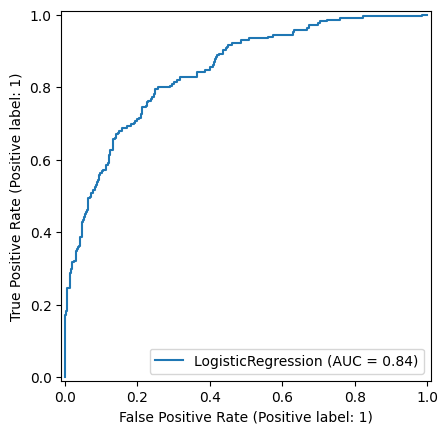

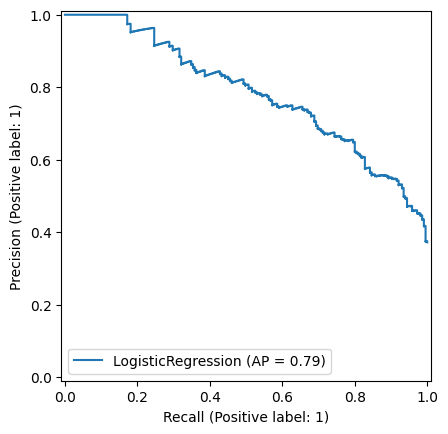

In [58]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [59]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [60]:
roc_df.to_csv(
    "roc/renal.tsv",
    sep="\t"
)

# Probability Prediction

In [61]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [62]:
predict_data = predict_data[protein_columns].copy()

In [63]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [64]:
predict_data['renal_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [65]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['renal_probability']
).reset_index()

In [66]:
predict_data[['renal_probability']].to_csv(
    "predictions_test/renal.tsv",
    sep="\t"
)

<Axes: xlabel='renal_probability', ylabel='Count'>

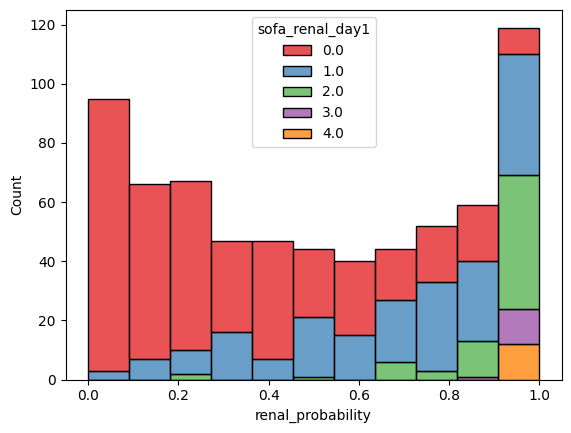

In [67]:
sns.histplot(
    data=design_matrix_test,
    x="renal_probability",
    hue="sofa_renal_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack"
)

In [68]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [69]:
val_data = val_data[protein_columns].copy()

In [70]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [71]:
val_data['renal_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [72]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['renal_probability']
).reset_index()

In [73]:
val_data[['renal_probability']].to_csv(
    "predictions_val/renal.tsv",
    sep="\t"
)

<Axes: xlabel='renal_probability', ylabel='Count'>

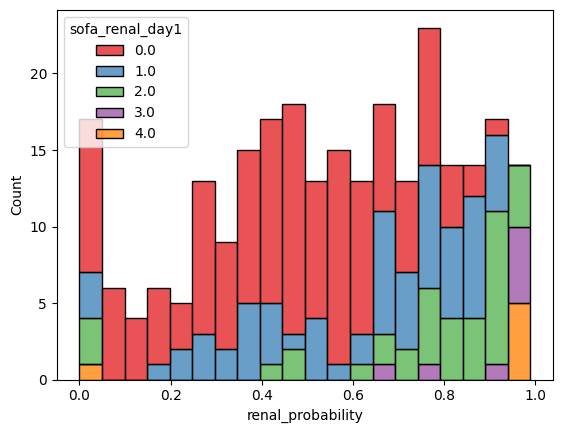

In [74]:
sns.histplot(
    data=design_matrix_val,
    x="renal_probability",
    hue="sofa_renal_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [75]:
val_data

,FIBA_HUMAN,TRFE_HUMAN,CFAH_HUMAN,CERU_HUMAN,GELS_HUMAN,VWF_HUMAN,CO7_HUMAN,A2MG_HUMAN,HPT_HUMAN,A2AP_HUMAN,...,LIRB1_HUMAN,EPCR_HUMAN,ADA2_HUMAN,MA2A1_HUMAN,PTPRG_HUMAN,FUCO_HUMAN,LAMP2_HUMAN,EIF3M_HUMAN,ACTB_HUMAN,renal_probability
SA_BOX1_1560_S1-G1_1_4421,-0.158417,0.509310,0.699778,0.393011,0.648473,0.143483,0.782717,0.852105,-0.204378,-0.121618,...,0.746596,0.666141,0.954150,0.757842,0.717647,0.955667,0.284339,1.313453,0.052772,0.899064
SA_BOX1_1679_S1-G10_1_4494,0.291403,0.515325,0.539522,0.733253,0.692496,-1.219093,0.184151,-0.038484,-0.550769,0.173276,...,0.341806,-1.592306,0.493832,0.486769,0.777347,0.620007,-0.356553,1.177632,0.380788,0.776464
SA_BOX1_1765_S1-D1_1_4418,0.755355,0.628183,0.361336,0.343028,0.916245,1.550597,0.822362,0.446039,0.300207,0.486642,...,0.961663,0.256295,0.484027,0.264945,0.890504,-0.665292,0.771457,0.487767,0.359267,0.873546
SA_BOX1_1785_S1-C11_1_4498,-0.103806,-0.469555,0.371392,0.367321,0.099266,-1.166185,-0.176907,0.188495,-0.041683,0.342875,...,-0.228425,-1.177993,-0.046007,0.026696,0.464644,0.477002,-0.273191,0.283092,-0.271680,0.184547
SA_BOX1_1791_S1-G11_1_4502,-0.371213,0.587952,0.490601,-0.143010,0.708966,-1.036660,0.413313,0.552134,-0.741201,0.067707,...,0.959464,-1.377348,0.553788,0.338191,0.414719,0.610250,0.222154,1.593269,-0.223780,0.234464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SA_BOX1_1209_S1-F5_1_4452,-4.249992,-2.271368,-4.658107,1.313773,-4.028478,-1.236022,-4.948146,0.626514,-3.241737,-4.625131,...,-1.688033,-1.523364,-2.588318,-2.709000,-2.881809,-1.847721,-2.409028,-4.310504,-4.175930,0.001127
SA_BOX1_1355_S1-F8_1_4477,-4.158850,-0.763324,-4.585953,-6.687143,-4.211432,-1.285827,-4.367142,-0.011912,1.096018,-4.600431,...,-1.799793,-1.327424,-2.544126,-2.575131,-3.518689,-1.678173,-2.206997,-3.935871,-4.498001,0.011232
SA_BOX1_1924_S1-F9_1_4485,-4.483643,-1.132605,-4.710954,2.062236,-4.379897,-1.006831,-4.575290,-1.377441,-3.355217,-4.648288,...,-1.977525,-1.593098,-2.575424,-2.880733,-2.904148,-2.080040,-2.282397,-4.123399,-4.226254,0.000080
SA_BOX1_1022_S1-F4_1_4444,-4.438655,-0.989596,-4.438603,1.765572,-4.441031,-1.238002,-4.730771,-9.332197,-2.970760,-4.489237,...,-1.971893,-1.128991,-2.541594,-2.488923,-3.505792,-1.933249,-2.377880,-3.938520,-4.468900,0.000504


In [76]:
X

,FIBA_HUMAN,TRFE_HUMAN,CFAH_HUMAN,CERU_HUMAN,GELS_HUMAN,VWF_HUMAN,CO7_HUMAN,A2MG_HUMAN,HPT_HUMAN,A2AP_HUMAN,...,IL1AP_HUMAN,LIRB1_HUMAN,EPCR_HUMAN,ADA2_HUMAN,MA2A1_HUMAN,PTPRG_HUMAN,FUCO_HUMAN,LAMP2_HUMAN,EIF3M_HUMAN,ACTB_HUMAN
SA_BOX_1-462_S1-C8_1_6848,-1.029013,0.713367,-1.328853,-0.166896,0.447192,-1.141389,-2.612304,-0.475017,-0.793517,1.892094,...,1.905953,0.027820,-1.209752,-0.067367,0.734985,0.279562,0.861290,0.709511,0.136157,-1.160169
SA_BOX_9-2606_S1-A5_1_6136,0.815136,-1.098543,0.593342,0.330522,-0.408397,-0.964621,-0.959724,0.770992,0.555951,-0.148751,...,-1.295404,0.463491,-1.408611,0.764952,-1.003011,-0.290622,0.014224,0.487153,0.058815,0.559072
SA_BOX_3-2442_S4-H8_1_5579,-0.209121,0.331724,1.177964,0.666625,0.023964,-0.148500,-0.096344,1.338294,0.145690,1.227016,...,-1.031156,0.532986,0.290341,0.547096,0.769534,0.107317,0.874127,-0.127102,0.339929,-0.206521
SA_BOX_2-1644_S2-A10_1_6960,0.923198,0.566673,-0.607061,-0.779773,0.428512,0.255162,0.039559,0.365559,0.185131,0.011698,...,-0.251828,0.258662,-1.339163,0.043038,0.549407,0.475503,0.624000,0.043692,0.200749,0.157905
SA_BOX_4-2435_S5-E11_1_5698,-0.936945,0.775633,1.227339,-0.710150,1.757199,1.070997,-0.243344,0.453851,-0.779052,-0.659903,...,0.616093,0.590208,0.496207,0.015935,0.910850,0.711553,0.664640,0.275023,1.136742,-0.818569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SA_BOX_11-2056_S4-F8_1_6362,1.071377,-0.548864,0.579702,0.911484,0.384807,-1.009959,0.028006,0.047774,0.279770,0.485964,...,0.367952,0.303974,-1.369144,-0.256926,0.470032,0.305068,0.423581,0.414006,0.293072,0.836016
SA_BOX_3-697_S4-A6_1_5555,-1.213672,1.141937,0.642386,0.688289,0.688642,-0.859152,0.715684,0.381765,-0.593040,1.357249,...,1.010056,0.313553,0.580337,-0.866911,0.753940,0.092037,0.783164,-0.544551,1.001537,-1.823456
SA_BOX_8-2367_S5-C12_1_6096,1.621427,-0.771857,0.164578,-0.140766,-0.747463,0.797005,1.400935,-0.433143,0.813859,1.020837,...,-0.719060,1.140477,0.955141,0.829410,0.852372,0.579624,0.992484,0.666496,-0.701565,1.280691
SA_BOX_4-2564_S5-F11_1_5699,-0.365612,0.428572,0.941417,0.372113,0.028789,-0.353394,0.026392,1.513780,-2.620858,-0.040949,...,-0.917355,0.512396,-1.203944,0.241644,0.640113,-0.750266,0.250939,0.409726,0.308297,-1.100609


In [77]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [78]:
hero_data = hero_data[protein_columns].copy()

In [79]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [80]:
hero_data['renal_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [81]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['renal_probability']
).reset_index()

In [82]:
hero_data[['renal_probability']].to_csv(
    "predictions_external/renal.tsv",
    sep="\t"
)

<Axes: xlabel='renal_probability', ylabel='Count'>

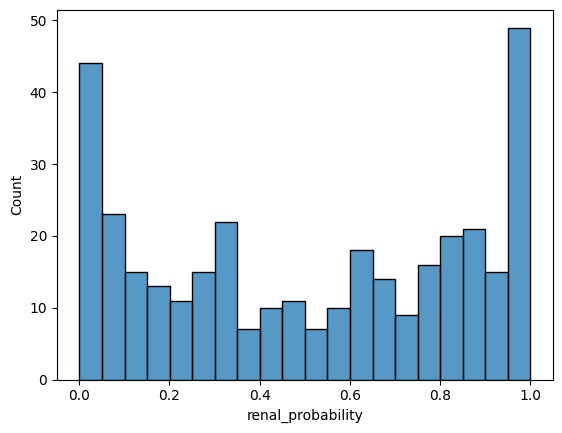

In [83]:
sns.histplot(
    data=hero_data,
    x="renal_probability",
    #hue="sofa_renal_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [84]:
hero_check = hero_data[protein_columns]
hero_check['Dataset'] = "Hero"

In [85]:
test_check = X_test[protein_columns]
test_check['Dataset'] = "Test"

In [86]:
train_check = X[protein_columns]
train_check['Dataset'] = "Train"

In [87]:
val_check = val_data[protein_columns]
val_check['Dataset'] = "Val"

In [88]:
combined_check = pd.concat(
    [
        hero_check, 
        test_check, 
        train_check, 
        val_check
    ]
)

In [89]:
from umap import UMAP

reducer = UMAP(n_components=2)

components = reducer.fit_transform(
    combined_check[protein_columns]
)

In [90]:
combined_check['UMAP 1'] = components[:, 0]
combined_check['UMAP 2'] = components[:, 1]

<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

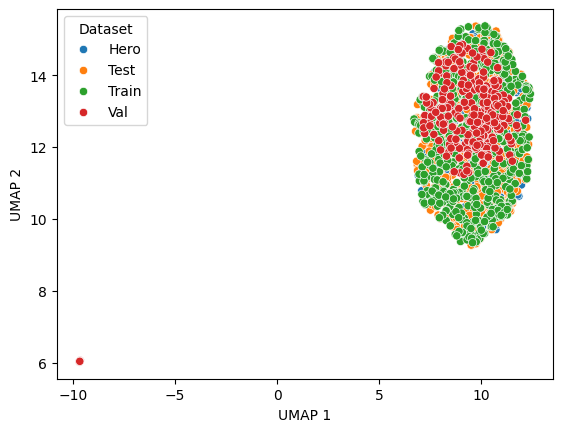

In [91]:
sns.scatterplot(
    data=combined_check,
    x="UMAP 1",
    y="UMAP 2",
    hue="Dataset"
)

In [92]:
from joblib import dump


with open("models/renal_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/renal_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
